Feature engineering

In [1]:
from datetime import datetime, timedelta
import pandas as pd
import matplotlib.pyplot as plt 


Load raw train data

In [2]:
data = pd.read_csv('/Users/jayshreesrinivasan/Downloads/weather_features_target_v1.csv')
data.target.value_counts()
data.head()

date      time  temperature_2m  relative_humidity_2m  dew_point_2m  \
0  2020-01-01  00:00:00       58.700300             62.268870       45.8303   
1  2020-01-01  01:00:00       54.380302             61.066536       41.2403   
2  2020-01-01  02:00:00       57.080300             50.207703       38.7203   
3  2020-01-01  03:00:00       50.420300             65.645630       39.3503   
4  2020-01-01  04:00:00       53.120300             54.411290       37.1003   

   apparent_temperature  precipitation  et0_fao_evapotranspiration  \
0             55.678288            0.0                    0.004173   
1             50.515940            0.0                    0.001316   
2             53.103203            0.0                    0.000875   
3             46.027035            0.0                    0.000634   
4             49.102360            0.0                    0.000436   

   wind_speed_100m  wind_direction_100m            date_time  is_possible_ff  \
0         6.215479            239.74365  2020-01-01 00:00:00           False   
1         4.529580            212.90524  2020-01-01 01:00:00           False   
2         0.316360            224.99990  2020-01-01 02:00:00           False   
3         4.343468            168.11136  2020-01-01 03:00:00           False   
4         3.472758            194.93147  2020-01-01 04:00:00           False   

   target  
0       0  
1       0  
2       0  
3       0  
4       0

In [4]:
# Drop redundant columns
duplicate_col = ['date', 'time', 'is_possible_ff']
data.drop(columns=duplicate_col, inplace=True)

Time based features

In [5]:
# Make sure date_time column is in the right dtype (datetime) and not object
data['date_time'] = pd.to_datetime(data['date_time'])

In [6]:
# For seasonal patterns

data['year'] = data['date_time'].dt.year
data['month'] = data['date_time'].dt.month
data['day_of_year'] = data['date_time'].dt.dayofyear

# For day patterns
data['hour'] = data['date_time'].dt.hour

# For week patterns
data['day_of_week'] = data['date_time'].dt.dayofweek  # Monday=0, Sunday=6
data['week_of_year'] = data['date_time'].dt.isocalendar().week
data['week_of_year'] = data.week_of_year.astype('int32') 
# For month patterns

data['is_month_start'] = data['date_time'].dt.is_month_start
data['is_month_end'] = data['date_time'].dt.is_month_end

data.head()

temperature_2m  relative_humidity_2m  dew_point_2m  apparent_temperature  \
0       58.700300             62.268870       45.8303             55.678288   
1       54.380302             61.066536       41.2403             50.515940   
2       57.080300             50.207703       38.7203             53.103203   
3       50.420300             65.645630       39.3503             46.027035   
4       53.120300             54.411290       37.1003             49.102360   

   precipitation  et0_fao_evapotranspiration  wind_speed_100m  \
0            0.0                    0.004173         6.215479   
1            0.0                    0.001316         4.529580   
2            0.0                    0.000875         0.316360   
3            0.0                    0.000634         4.343468   
4            0.0                    0.000436         3.472758   

   wind_direction_100m           date_time  target  year  month  day_of_year  \
0            239.74365 2020-01-01 00:00:00       0  2020      1            1   
1            212.90524 2020-01-01 01:00:00       0  2020      1            1   
2            224.99990 2020-01-01 02:00:00       0  2020      1            1   
3            168.11136 2020-01-01 03:00:00       0  2020      1            1   
4            194.93147 2020-01-01 04:00:00       0  2020      1            1   

   hour  day_of_week  week_of_year  is_month_start  is_month_end  
0     0            2             1            True         False  
1     1            2             1            True         False  
2     2            2             1            True         False  
3     3            2             1            True         False  
4     4            2             1            True         False

Finding feature importance
LOFO (Leave One Feature Out) Importance calculates the importances of a set of features based on a metric of choice, for a model of choice, by iteratively removing each feature from the set, and evaluating the performance of the model, with a validation scheme of choice, based on the chosen metric.

LOFO first evaluates the performance of the model with all the input features included, then iteratively removes one feature at a time, retrains the model, and evaluates its performance on a validation set. The mean and standard deviation (across the folds) of the importance of each feature is then reported.

If a model is not passed as an argument to LOFO Importance, it will run LightGBM as a default model.

In [7]:
%pip install lofo-importance


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [8]:

data.dtypes
g = data.columns.to_series().groupby(data.dtypes).groups
{k.name: v for k, v in g.items()}

{'float64': Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
        'apparent_temperature', 'precipitation', 'et0_fao_evapotranspiration',
        'wind_speed_100m', 'wind_direction_100m'],
       dtype='object'),
 'datetime64[ns]': Index(['date_time'], dtype='object'),
 'bool': Index(['is_month_start', 'is_month_end'], dtype='object'),
 'int32': Index(['year', 'month', 'day_of_year', 'hour', 'day_of_week', 'week_of_year'], dtype='object'),
 'int64': Index(['target'], dtype='object')}

Since all the columns have the correct data types, we don't need to change anything. Let's define the input features to find importance of and the target.

In [9]:
target = "target"

features = [col for col in data.columns if col not in {"target", "date_time", }]

In [10]:
import lofo

ds = lofo.Dataset(data, target=target, features=features, auto_group_threshold=0.85)

/opt/homebrew/lib/python3.11/site-packages/lofo/lofo_importance.py:3: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


Automatically grouped features by correlation:
1 ['apparent_temperature', 'temperature_2m']
2 ['day_of_year', 'month', 'week_of_year']


Metrics:
We can try different classification metrics to let LOFO optimize for. Since out dataset is imbalanced, lets first try with balanced_accuracy.

Model:
If not specified, LOFO trains lightGBM model. It could be an overkill model to use for feature selection to start off with, therefore we will select some simpler statistical models and then move to complex ML.

In [11]:
metric = "balanced_accuracy"
#model = 

lofo_imp = lofo.LOFOImportance(ds, cv=5, scoring=metric)
imp_df = lofo_imp.get_importance()

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001316 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2188
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 16
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

  0%|          | 0/13 [00:00<?, ?it/s]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001246 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

  8%|▊         | 1/13 [00:02<00:28,  2.36s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000946 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 15%|█▌        | 2/13 [00:04<00:25,  2.33s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000965 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 23%|██▎       | 3/13 [00:06<00:22,  2.30s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000799 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2185
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 31%|███       | 4/13 [00:09<00:20,  2.32s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000658 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2126
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 38%|███▊      | 5/13 [00:11<00:18,  2.30s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001036 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2164
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Info] Number of positive: 793, number of negative: 27277
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000956 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2187
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [bin

 46%|████▌     | 6/13 [00:14<00:16,  2.36s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000957 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 54%|█████▍    | 7/13 [00:16<00:14,  2.34s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000840 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2182
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 62%|██████▏   | 8/13 [00:18<00:11,  2.33s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000787 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2185
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 69%|██████▉   | 9/13 [00:20<00:09,  2.33s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000895 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2181
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 77%|███████▋  | 10/13 [00:23<00:07,  2.37s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000835 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1933
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 85%|████████▍ | 11/13 [00:25<00:04,  2.44s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001079 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1678
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 14
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

 92%|█████████▏| 12/13 [00:28<00:02,  2.58s/it]

[LightGBM] [Info] Number of positive: 794, number of negative: 27276
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000902 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1890
[LightGBM] [Info] Number of data points in the train set: 28070, number of used features: 13
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.028286 -> initscore=-3.536679
[LightGBM] [Info] Start training from score -3.536679
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

100%|██████████| 13/13 [00:31<00:00,  2.44s/it]


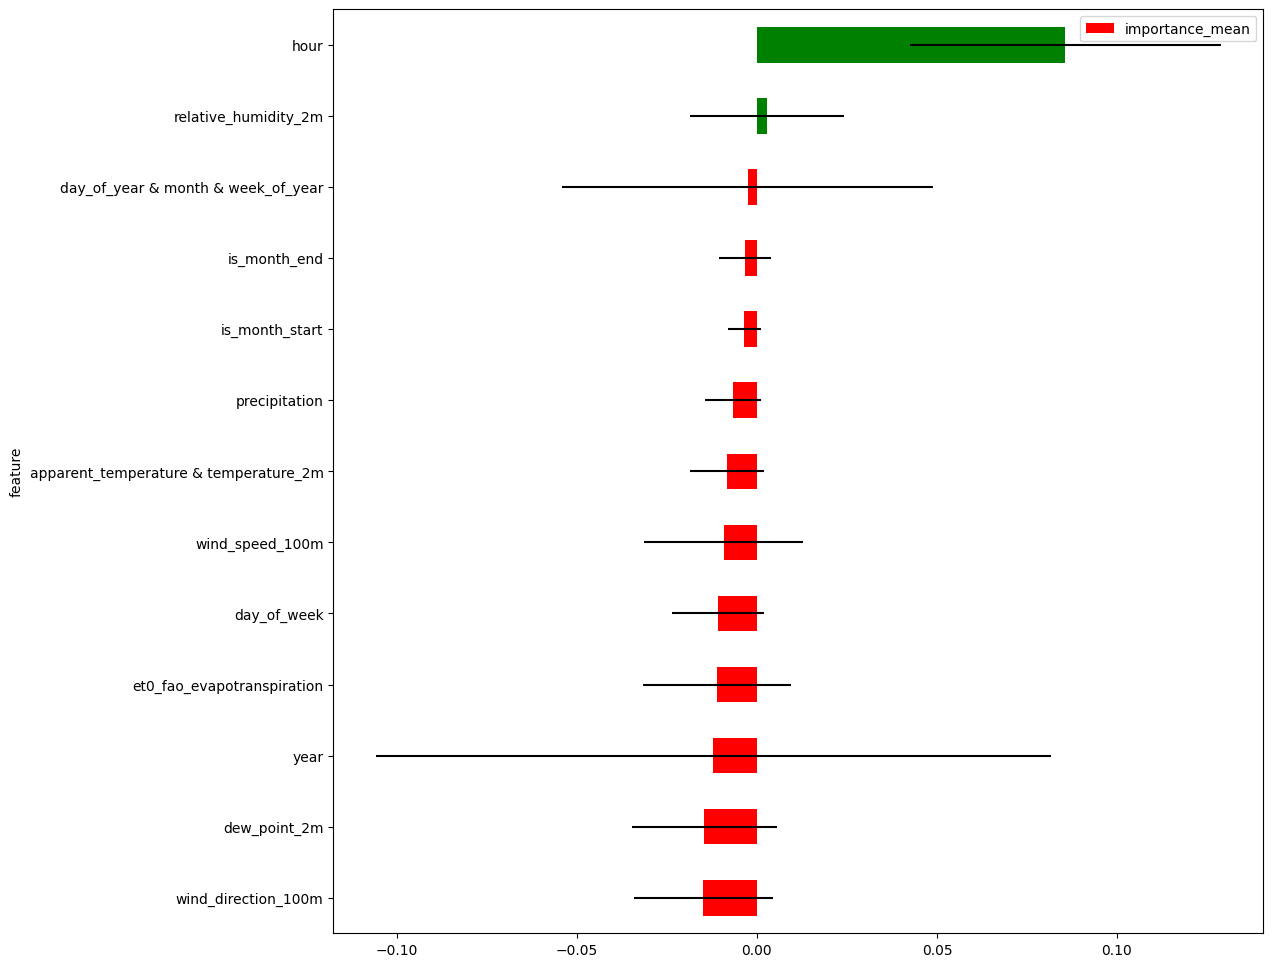

In [12]:
imp_df["feature"] = imp_df["feature"].str[:64]

lofo.plot_importance(imp_df, figsize=(12, 12))

In [13]:
important_features = ['hour', 'relative_humidity_2m']


TabNet (Neural Network)
Now that we've engineered few features and found the importance of all of them, let's try to train a model.

Here, we will train a Neural Network called TabNet: Attentive Interpretable Tabular Learning

In [14]:
%pip install pytorch-tabnet scikit-learn


[notice] A new release of pip is available: 24.3.1 -> 25.0.1
[notice] To update, run: python3.11 -m pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [15]:
import torch
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.preprocessing import LabelEncoder


tabnet = TabNetClassifier(optimizer_fn=torch.optim.Adam,
    optimizer_params=dict(lr=2e-3),
    scheduler_params={"step_size":10, # how to use learning rate scheduler
    "gamma":0.9},
    scheduler_fn=torch.optim.lr_scheduler.StepLR,
    n_d=4,
    n_a=4)

/opt/homebrew/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:82: UserWarning: Device used : cpu
  warnings.warn(f"Device used : {self.device}")


In [16]:
def train_and_evaluate(model, X, Y, model_name):
    roc_auc_scores = []
    kf = KFold(n_splits=5, shuffle=True, random_state=42)

    for train_index, test_index in kf.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        Y_train, Y_test = Y.iloc[train_index], Y.iloc[test_index]

        if model_name == "TabNet":
            model.fit(X_train.values, Y_train.values, max_epochs=20)
        else:
            model.fit(X_train, Y_train)

        if model_name == "TabNet":
            preds = model.predict(X_test.values)
        else:
            preds = model.predict_proba(X_test)[:, 1]

        score = roc_auc_score(Y_test, preds)
        roc_auc_scores.append(score)
        print(f"{model_name} - ROC AUC Score: {score:.5f}")

    avg_roc_auc = np.mean(roc_auc_scores)
    print(f"\nAverage ROC AUC for {model_name}: {avg_roc_auc:.5f}")
    return model, avg_roc_auc

In [17]:
data.columns

Index(['temperature_2m', 'relative_humidity_2m', 'dew_point_2m',
       'apparent_temperature', 'precipitation', 'et0_fao_evapotranspiration',
       'wind_speed_100m', 'wind_direction_100m', 'date_time', 'target', 'year',
       'month', 'day_of_year', 'hour', 'day_of_week', 'week_of_year',
       'is_month_start', 'is_month_end'],
      dtype='object')

In [18]:
X = data.drop(columns=['target', 'date_time'])
Y = data['target']

In [ ]:
model_tabnet, avg_roc_auc_tabnet = train_and_evaluate(tabnet, X, Y, "TabNet")

/opt/homebrew/lib/python3.11/site-packages/pytorch_tabnet/abstract_model.py:687: UserWarning: No early stopping will be performed, last training weights will be used.
  warnings.warn(wrn_msg)


In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns 

data = pd.read_csv("/Users/jayshreesrinivasan/Downloads/Hourly_Weather_Dataset.csv")

print(data.columns)





Index(['date', 'time', 'Severity', 'temperature_2m', 'relative_humidity_2m',
       'precipitation', 'surface_pressure', 'cloud_cover', 'wind_speed_10m',
       'soil_temperature_0_to_7cm', 'soil_temperature_7_to_28cm',
       'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm', 'forest_fire'],
      dtype='object')


In [29]:
# datetime format
data['date'] = pd.to_datetime(data['date'], errors='coerce')

# filter rows to when fire happened
fire_weather_data = data[data['forest_fire'] == 'Y']

# Select the relevant weather variables
fire_weather_summary = fire_weather_data[['temperature_2m', 'relative_humidity_2m', 'precipitation', 'surface_pressure', 
                                          'cloud_cover', 'wind_speed_10m', 'soil_temperature_0_to_7cm', 
                                          'soil_temperature_7_to_28cm', 'soil_moisture_0_to_7cm', 
                                          'soil_moisture_7_to_28cm']].describe()

fire_weather_summary

/var/folders/gf/p0vs4k250g73cypf421ghf_80000gn/T/ipykernel_23328/3646954209.py:2: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  data['date'] = pd.to_datetime(data['date'], errors='coerce')


temperature_2m  relative_humidity_2m  precipitation  surface_pressure  \
count     6422.000000           6422.000000    6422.000000       6422.000000   
mean        25.996273             34.224443       0.000903        949.672409   
std          7.913216             24.082342       0.058899         28.432783   
min          1.674000              5.358259       0.000000        877.011100   
25%         20.220500             17.009457       0.000000        929.109423   
50%         27.153250             23.622296       0.000000        946.519400   
75%         31.646000             46.048367       0.000000        966.229570   
max         42.581500            100.000000       4.700000       1019.041750   

       cloud_cover  wind_speed_10m  soil_temperature_0_to_7cm  \
count  6422.000000     6422.000000                6422.000000   
mean      8.362473       10.069481                  27.822044   
std      14.618566        4.914597                   8.105363   
min       0.000000        0.360000                   2.331000   
25%       0.000000        5.692099                  23.003000   
50%       0.900000       10.009036                  28.786750   
75%      12.599999       14.039999                  32.641251   
max     100.000000       24.480000                  44.717000   

       soil_temperature_7_to_28cm  soil_moisture_0_to_7cm  \
count                 6422.000000             6422.000000   
mean                    27.344412                0.145445   
std                      5.848311                0.058268   
min                      5.473500                0.066000   
25%                     24.805125                0.125000   
50%                     28.067751                0.133000   
75%                     31.519000                0.137000   
max                     35.836500                0.503000   

       soil_moisture_7_to_28cm  
count              6422.000000  
mean                  0.176606  
std                   0.065136  
min                   0.126000  
25%                   0.149000  
50%                   0.152000  
75%                   0.157000  
max                   0.511000

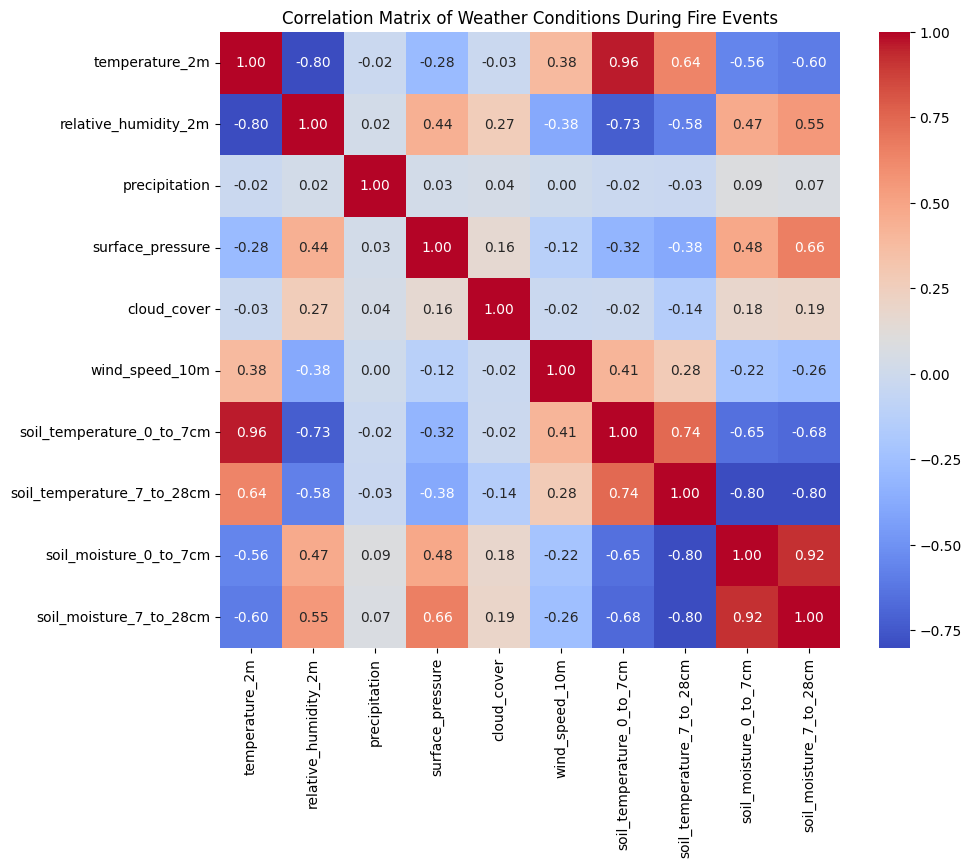

In [30]:
# Weather conditions when fires happened
correlation_data = fire_weather_data[['temperature_2m', 'relative_humidity_2m', 'precipitation', 'surface_pressure', 
                                      'cloud_cover', 'wind_speed_10m', 'soil_temperature_0_to_7cm', 
                                      'soil_temperature_7_to_28cm', 'soil_moisture_0_to_7cm', 'soil_moisture_7_to_28cm']]


corr_matrix = correlation_data.corr()

# Correlation Matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm', cbar=True)
plt.title('Correlation Matrix of Weather Conditions During Fire Events')
plt.show()
